# Merge example

In our publication we proposed merging instance results over performing standard non-maximum suppression. This notebook aims to illustrate our implementation of the merging algorithm.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import glob
import albumentations as A


# Root directory of the project
ROOT_DIR = os.path.abspath(os.getcwd())

# Import Mask RCNN 
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import stats_utils

import Monuseg

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MONUSEG_DIR = os.path.join(ROOT_DIR, "datasets","monuseg")
config = Monuseg.MonusegInferenceConfig()


c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

In [2]:
# Load dataset - 
subset = "val"
dataset_dir = os.path.join(MONUSEG_DIR, subset)
image_dir = os.path.join(dataset_dir, "tissue_images")
image_ids = os.listdir(image_dir)
print("Found {} images in {}".format(len(image_ids), image_dir))


dataset = Monuseg.MonusegDataset("UNET")
dataset.add_class(source = "Monuseg", class_id =  1, class_name = "nucleus")

# Fill with the samples
i = 0
for _id in image_ids:
    name,_ = os.path.splitext(_id)
    if i <= len(image_ids):
        dataset.add_image(source = "Monuseg",
                                image_id = name,
                                path = os.path.join(image_dir, _id))
    i+=1    

    
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Found 14 images in C:\Users\User\GitHub\Improved Mask R-CNN\datasets\Monuseg\val\tissue_images
Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


Get some example detections from the PanNuke Ensemble

In [3]:
path_list = [
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold0\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold1\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold2\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold3\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold4\Detections"
]
confidence_thresh = 0.7 # Min average confidence of the ensemble for positive pixel segmentation
iou_thresh = 0.3 # Min IoU for matching instances (relatively high)

Load data

TCGA-AO-A0J2-01A-01-BSA
(1000, 1000, 2274)
(2274, 4)


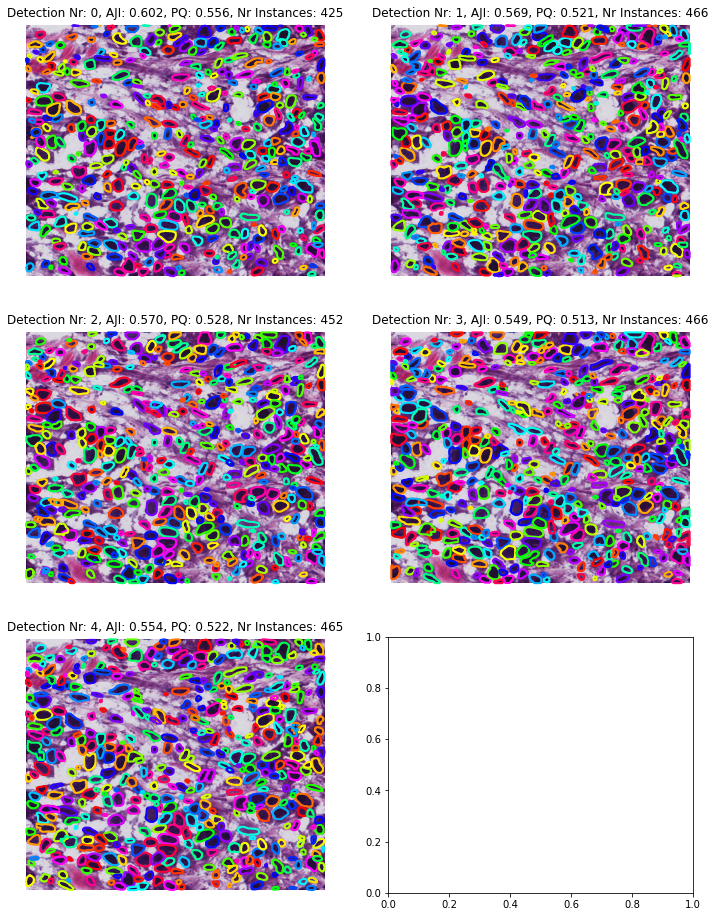

In [4]:
_id = 5
img = dataset.load_image(_id)[:,:,0:3]
gt_mask = dataset.load_mask(_id)[0]
info = dataset.image_info[_id]
n = info["id"]
print(n)
all_masks = []
# Load exsting detections (float)
fig, axs = plt.subplots(3,2, figsize=(12, 16))
axs = np.ravel(axs)

for i, p in enumerate(path_list):
    m = np.load(os.path.join(p, n + "_masks.npz"))["arr_0"]
    m = ((m / np.max(m)) * 255).astype(np.uint8) # convert to uint8 for memory/performance
    sc = np.load(os.path.join(p, n + "_scores.npy"))
    aji, pq = utils.calc_aji_pq(m > confidence_thresh * 255, gt_mask)
    visualize.display_instances(img, utils.extract_bboxes(m), m > confidence_thresh*255, np.ones(m.shape[-1]),
                            dataset.class_names, show_bbox=False, show_mask=False, use_captions = False, ax = axs[i])  
    axs[i].set_title("Detection Nr: {}, AJI: {:3.3f}, PQ: {:3.3f}, Nr Instances: {}".format(i, aji, pq, m.shape[-1]))   
    all_masks.append(m)
    
    
all_masks = np.concatenate(all_masks, axis = -1)
print(all_masks.shape)

all_bboxes = utils.extract_bboxes(all_masks > confidence_thresh * 255) # for preliminary bboxes
print(all_bboxes.shape)

Deconstructed and stopped example with one step in the merging, displays what is being merged with what:

Merged: idx 0 with idxs [ 603  951 1481 1942]
Box coordinates were:
[911 273 934 320]
[[909 271 936 321]
 [911 273 935 321]
 [909 271 936 319]
 [909 270 936 321]]


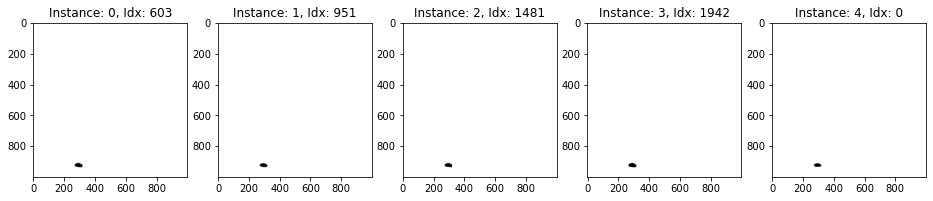

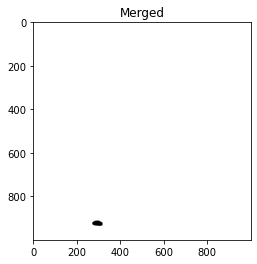

In [5]:
_all_masks = all_masks.copy()
_all_bboxes = all_bboxes.copy()

ret_mask = []
counter = np.array(range(_all_bboxes.shape[0])) # get instance indices
n = 0
maxi = 1 #_all_bboxes.shape[0]

y1 = _all_bboxes[:, 0]
x1 = _all_bboxes[:, 1]
y2 = _all_bboxes[:, 2]
x2 = _all_bboxes[:, 3]
area = (y2 - y1) * (x2 - x1)

fig, axs = plt.subplots(1,5, figsize = (16,16))

while n < maxi: # Run this example for 1 step (In code go through all bboxes)
    if counter[n] == -1: # If the instance has been matched before - skip
        n+=1
        continue
    else:
        i = counter[n] # Take bbox (-index)
        # Get IoU with all other boxes (skip the first, which we have atm to avoid errors)
        iou = utils.compute_iou(_all_bboxes[i], _all_bboxes[1:], area[i], area[1:]) 
        # Get indices of boxes with iou > thresh, (+1 for skipped box)
        idxs = np.where(iou > iou_thresh)[0] + 1 
        matches = np.append(idxs, counter[0]) # Add current box
        if len(matches) > 2: # If majority of models saw something at this intersection
            inst_mask = all_masks[:,:,matches]
            for ii in range(inst_mask.shape[-1]):
                axs[ii].imshow(inst_mask[:,:,ii], cmap = "binary")
                axs[ii].set_title("Instance: {}, Idx: {}".format(ii, matches[ii]))
            # Merge by average voting
            inst_mask = np.mean(inst_mask, axis = -1) > confidence_thresh * 255   
            ret_mask.append(inst_mask)
            print("Merged: idx {} with idxs {}".format(i, idxs))
            print("Box coordinates were:")
            print(_all_bboxes[i])
            print(_all_bboxes[idxs])

        # Set visited boxes to -1, continue
        counter[np.isin(counter, matches)] = -1
    plt.figure()
    plt.imshow(inst_mask, cmap = "binary")
    plt.title("Merged")
    n+=1
    
ret_mask = np.array(ret_mask)
ret_mask = ret_mask.transpose(1,2,0)

Run through the whole loop

In [8]:
_all_masks = all_masks.copy()
_all_bboxes = all_bboxes.copy()

ret_mask = []
counter = np.array(range(_all_bboxes.shape[0])) 
n = 0
maxi = _all_bboxes.shape[0]

y1 = _all_bboxes[:, 0]
x1 = _all_bboxes[:, 1]
y2 = _all_bboxes[:, 2]
x2 = _all_bboxes[:, 3]
area = (y2 - y1) * (x2 - x1)


while n < maxi: 
    if counter[n] == -1: 
        n+=1
        continue
    else:
        i = counter[n] 
        
        iou = utils.compute_iou(_all_bboxes[i], _all_bboxes[1:], area[i], area[1:]) 

        idxs = np.where(iou > iou_thresh)[0] + 1 
        matches = np.append(idxs, counter[0]) 
        if len(matches) > 2: 
            inst_mask = all_masks[:,:,matches]
            # Merge by average voting
            inst_mask = np.mean(inst_mask, axis = -1) > confidence_thresh * 255   
            ret_mask.append(inst_mask)
        # Set visited boxes to -1, continue
        counter[np.isin(counter, matches)] = -1
    n+=1
    
ret_mask = np.array(ret_mask)
ret_mask = ret_mask.transpose(1,2,0)

Calc and display AJI, PQ - show data

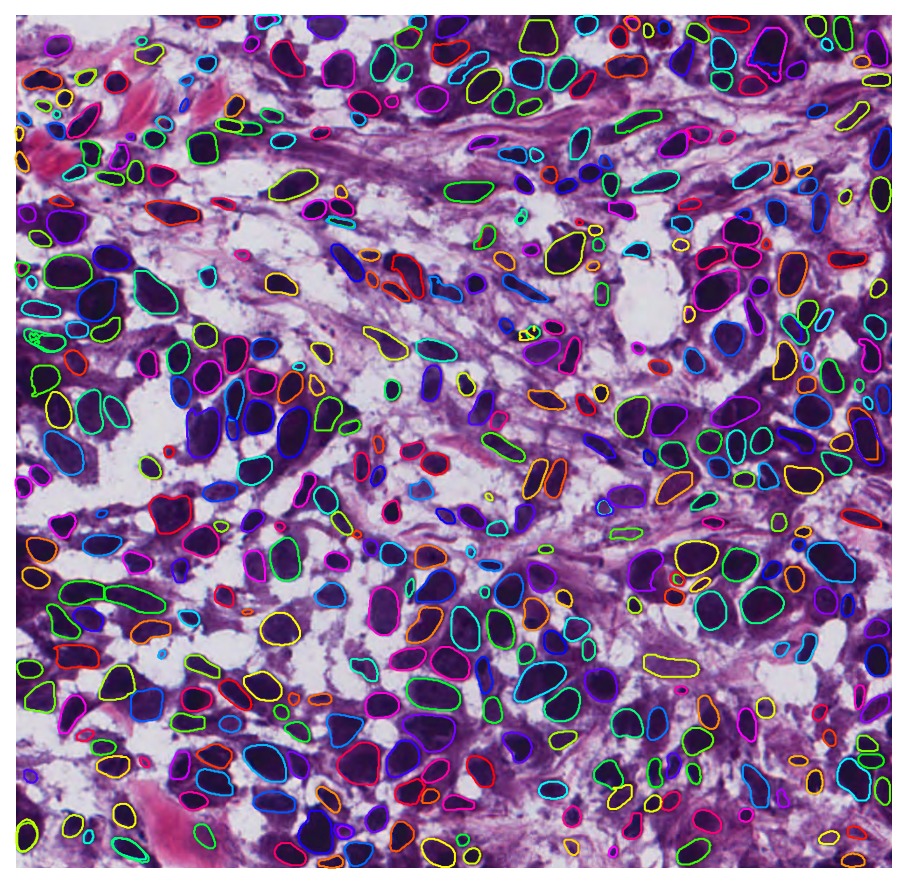

AJI: 0.591, PQ: 0.533


In [9]:
visualize.display_instances(img, utils.extract_bboxes(ret_mask), ret_mask, np.ones(ret_mask.shape[-1]), 
                            ["BG", ""], np.ones(ret_mask.shape[-1]), use_captions=False, show_mask = False, show_bbox = False)

aji, pq = utils.calc_aji_pq(ret_mask, gt_mask)
print("AJI: {:3.3f}, PQ: {:3.3f}".format(aji, pq))